In [3]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re

dataset_id = "PXD020586" # Indicate Dataset Here
accessions =  ["PXD020586", "PXD017626"] # "MSV000086004", "PXD016573", "MSV000086809", "PXD027742",

# Make a preliminary for loop that generates the whole list of datasets using filepath and append psm["File_Name"].unique()

i = 0
for accession in accessions:
    
    filepath = accession + "/psm.TSV"
    
    psm_df = pd.read_csv(filepath, delimiter = "\t")
  
    psm_df = psm_df.loc[psm_df["PeptideProphet Probability"] > 0.99]
    
    # psm_df = psm_df.rename(columns={'sample-01': '126',  'sample-02': '127C', 'sample-03': '127N', 'sample-04': '128C', 'sample-05': '128N', 'sample-06': '129C',
    #                                 'sample-07': '129N', 'sample-08': '130C', 'sample-09': '130N', 'sample-10': '131C', 'sample-11': '131N', 'sample-12': '132C',
    #                                 'sample-13': '132N', 'sample-14': '133C', 'sample-15': '133N', 'sample-16': '134N', 'sample-17': '134C', 'sample-18': '135N'})
    
    psm_df["File_Name"] = psm_df["Spectrum File"].str.extract(r"^(?:.+\\)*interact-(.+)\.pep\.xml$")
    
    if (i == 0):
        datasets = psm_df["File_Name"].unique()
    else:
        datasets = np.concatenate((datasets, psm_df["File_Name"].unique()))
    
    i = i + 1
    
# Then make the medians_df
# Then use another for loop to fill it in

print(datasets)

['20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S1'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S11'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S2'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S3'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S4'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S5'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S7'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S9'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S10'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S12'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S13'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S15'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S17'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S19'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S6'
 '20200515_MK_ES_E1200_precol_scMS_500ms_8227_P5_S8'
 '20200516_MK_ES_E1200_precol_scMS_500ms_8227_P5_S14'
 '20200516_MK_ES_E1200_precol_scMS_500ms_8227_P5_S16'
 '20200516_MK_ES_E1200_precol_scMS_50

In [4]:
all_channels = ["126","127N","127C","128N","128C","129N","129C","130N","130C","131N","131C","132N","132C","133N","133C","134N","134C","135N"]
channels = ["127N","128N","128C","129N","129C","130N","130C","131N","131C","132N","132C","133N","133C","134N"]
medians_df = pd.DataFrame(index=datasets, columns=channels)
medians_df["Carrier Volume"] = ''

boost_volumes = set()

for accession in accessions:
    filepath = accession + "/psm.TSV"
    info_path = accession + "/sdrf.xlsx"
    
    psm_df = pd.read_csv(filepath, delimiter = "\t")
    sdrf_df = pd.read_excel(info_path)
    
    psm_df = psm_df.loc[psm_df["PeptideProphet Probability"] > 0.99]
    
    sdrf_df["label"] = sdrf_df["label"].astype(str)
    
    psm_df = psm_df.rename(columns={'sample-01': '126',  'sample-02': '127C', 'sample-03': '127N', 'sample-04': '128C', 'sample-05': '128N', 'sample-06': '129C',
                                    'sample-07': '129N', 'sample-08': '130C', 'sample-09': '130N', 'sample-10': '131C', 'sample-11': '131N', 'sample-12': '132C',
                                    'sample-13': '132N', 'sample-14': '133C', 'sample-15': '133N', 'sample-16': '134N', 'sample-17': '134C', 'sample-18': '135N'})
    
    psm_df["File_Name"] = psm_df["Spectrum File"].str.extract(r"^(?:.+\\)*interact-(.+)\.pep\.xml$")
    sdrf_df["File_Name"] = sdrf_df["file name"].str.extract(r"^(?:.+\\)*(.+)\.raw$")
    
    curr_datasets = psm_df["File_Name"].unique()
    
    curr_channels = []
    
    info_dict = {}
    
    for dataset in curr_datasets:
        info_dict[dataset] = sdrf_df.loc[sdrf_df["File_Name"] == dataset]
        
    first_info_df = info_dict[curr_datasets[0]]
    first_info_df.reset_index(drop=True, inplace=True)

    for channel in channels:
        if first_info_df.index[first_info_df["label"] == channel].tolist():
            row = first_info_df.index[first_info_df["label"] == channel].tolist()[0]
            channel_type = first_info_df["type"].iloc[row]

            if (channel_type == "single" or channel_type == "blank"): # May need to add condition that the channel is found in channels
                curr_channels.append(channel)

    psm_df = pd.melt(psm_df, id_vars=["File_Name"], value_vars=curr_channels)

    data_dict = {}
    for dataset in curr_datasets:
        data_dict[dataset] = psm_df.loc[psm_df["File_Name"] == dataset]
        
    
    for dataset in curr_datasets:
        info_df = info_dict[dataset]

        info_df.reset_index(drop=True, inplace=True)

        all_channels = info_df["label"]
        boost_volume = 0

        for channel in all_channels:
            row = info_df.index[info_df["label"] == channel].tolist()[0]
            channel_type = info_df["type"].iloc[row]
            if (channel_type == "boost"):
                boost_volume += info_df["cell_equivalents"].iloc[row]

        boost_volumes.add(boost_volume)


        medians_df.at[dataset, "Carrier Volume"] = boost_volume

    
    # print(curr_channels)
    # channels = ["127N","128N","128C","129N","129C","130N","130C"] # ,"131N","131C","132N","132C","133N","133C","134N"] #Excluding 126 and 127C because reasons

    
    
    for dataset in curr_datasets:
        curr_df =  data_dict[dataset]
        for channel in curr_channels:
            chan_df = curr_df.loc[curr_df["variable"] == channel]
            medians_df.at[dataset, channel] = chan_df['value'].median()

medians_df['Median'] = medians_df[channels].median(axis=1)

medians_df["Carrier Volume"] = pd.to_numeric(medians_df["Carrier Volume"], errors='coerce')
medians_df.sort_values(by=["Carrier Volume"], ascending=True)

medians_df["Carrier Volume"] = medians_df["Carrier Volume"].astype(int)
# medians_df["Carrier Volume"] = medians_df["Carrier Volume"].astype(str) + "x"


print(boost_volumes)

# psm_df
# sdrf_df
# first_info_df
medians_df
    
    
    
# psm_df["value"] = psm_df["value"].apply(np.log10)
# psm_df["value"] = np.log10(psm_df["value"].replace(0, np.nan))

{200.0, 100.0}


,127N,128N,128C,129N,129C,130N,130C,131N,131C,132N,132C,133N,133C,134N,Carrier Volume,Median
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S1,2217.7078,2580.886,2016.1881,2575.4722,2371.4612,2250.7793,2029.0525,2834.7368,2289.8716,2019.9855,4782.0962,1902.2795,1870.3403,1910.1562,200,2234.24355
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S11,2693.45105,2365.1373,2393.91675,1863.55395,2383.2102,1935.89615,2257.4703,2134.8656,1987.6201,1603.09165,2216.9878,2033.8354,1062.87345,1859.7593,200,2084.35050
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S2,2289.1697,2220.5723,1661.3906,1889.6298,2545.5549,1657.2594,1635.9067,2017.7406,2090.7185,1657.8379,1512.6743,1885.5625,1042.2257,1755.1449,200,1820.35370
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S3,2793.3025,2890.1731,2262.9099,1526.113,2115.6438,2349.9802,2212.5269,1956.1344,3013.4807,3163.1516,2491.6904,1958.0831,2132.375,2192.3572,200,2237.71840
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S4,2373.7463,2756.7847,2201.062,2151.7141,2600.4741,2166.6475,2176.9041,1343.9921,2343.2581,3019.7053,1372.7329,1933.9783,2718.7007,2186.9829,200,2194.02245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NanoPOTS_SingleCell_AML_TMT_B_04,NaN,780.8305,747.827,539.7092,672.8366,504.303,1337.8831,554.8636,485.0401,NaN,NaN,NaN,NaN,NaN,100,613.85010
NanoPOTS_SingleCell_AML_TMT_B_05,NaN,731.8951,774.2382,571.1293,440.48645,452.7513,428.19975,471.2284,329.402,NaN,NaN,NaN,NaN,NaN,100,461.98985
NanoPOTS_SingleCell_AML_TMT_B_06,NaN,779.2822,844.83315,648.3565,447.13395,499.9177,629.6129,480.71615,518.2436,NaN,NaN,NaN,NaN,NaN,100,573.92825
NanoPOTS_SingleCell_AML_TMT_B_07,NaN,744.5172,716.4517,458.5995,366.6278,415.5838,470.1054,582.0521,585.4424,NaN,NaN,NaN,NaN,NaN,100,526.07875


In [5]:
variance_df = pd.DataFrame(index=datasets, columns=channels)
variance_df = variance_df.assign(Boost=medians_df["Carrier Volume"])

for dataset in datasets:
    for channel in channels:
        variance_df.at[dataset, channel] = medians_df.at[dataset, channel] / medians_df.at[dataset, "Median"]

# sigmas = variance_df[channels].std()
sigma = np.nanstd(variance_df[channels])
mean = np.nanmean(variance_df[channels])
# print(sigmas)
print(sigma)
print(mean)

for dataset in datasets:
    for channel in channels:
        # curr_col = variance_df[channel]
        # variance_df = variance_df[(curr_col <= mean+(5*sigma))]
        
        if (variance_df.at[dataset, channel] > mean+(5*sigma)): 
            variance_df.at[dataset, channel] = np.nan
            
        
variance_df
# variance_df.to_csv("variance.csv")



0.5939470681523964
1.0726888169806919


,127N,128N,128C,129N,129C,130N,130C,131N,131C,132N,132C,133N,133C,134N,Boost
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S1,0.992599,1.15515,0.902403,1.152727,1.061416,1.007401,0.908161,1.268768,1.024898,0.904103,2.140365,0.85142,0.837125,0.854945,200
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S11,1.292226,1.134712,1.148519,0.894069,1.143383,0.928777,1.083057,1.024235,0.953592,0.769108,1.063635,0.975765,0.50993,0.892249,200
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S2,1.257541,1.219858,0.912675,1.038056,1.398385,0.910405,0.898675,1.108433,1.148523,0.910723,0.830978,1.035822,0.57254,0.964178,200
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S3,1.248282,1.291571,1.011258,0.681995,0.945447,1.050168,0.988742,0.874165,1.346676,1.413561,1.113496,0.875036,0.952924,0.979729,200
20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S4,1.081915,1.256498,1.003209,0.980717,1.185254,0.987523,0.992198,0.61257,1.068019,1.376333,0.625669,0.881476,1.23914,0.996791,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NanoPOTS_SingleCell_AML_TMT_B_04,NaN,1.272021,1.218257,0.87922,1.096093,0.821541,2.179495,0.903907,0.79016,NaN,NaN,NaN,NaN,NaN,100
NanoPOTS_SingleCell_AML_TMT_B_05,NaN,1.584223,1.675877,1.236238,0.953455,0.980003,0.92686,1.019997,0.713007,NaN,NaN,NaN,NaN,NaN,100
NanoPOTS_SingleCell_AML_TMT_B_06,NaN,1.357804,1.472019,1.129682,0.779076,0.871046,1.097024,0.837589,0.902976,NaN,NaN,NaN,NaN,NaN,100
NanoPOTS_SingleCell_AML_TMT_B_07,NaN,1.41522,1.361872,0.871732,0.696907,0.789965,0.893603,1.106397,1.112842,NaN,NaN,NaN,NaN,NaN,100


In [6]:
boost_volumes = set()

variance_df["Carrier Volume"] = ''

# variance_df["Injection Time"] = ''
for accession in accessions:
for dataset in datasets:
    info_df = info_dict[dataset]
    
    info_df.reset_index(drop=True, inplace=True)
    
    all_channels = info_df["label"]
    boost_volume = 0
    
    for channel in all_channels:
        row = info_df.index[info_df["label"] == channel].tolist()[0]
        channel_type = info_df["type"].iloc[row]
        if (channel_type == "boost"):
            boost_volume += info_df["cell_equivalents"].iloc[row]
    
    boost_volumes.add(boost_volume)
    
#     if "300ms" in dataset:
#         variance_df.at[dataset, "Injection Time"] = "300ms"
#         
#     elif "500ms" in dataset:
#         variance_df.at[dataset, "Injection Time"] = "500ms"
    
    variance_df.at[dataset, "Carrier Volume"] = boost_volume
    
variance_df["Carrier Volume"] = pd.to_numeric(variance_df["Carrier Volume"], errors='coerce')
variance_df.sort_values(by=["Carrier Volume"], ascending=True)

variance_df["Carrier Volume"] = variance_df["Carrier Volume"].astype(int)
# variance_df["Carrier Volume"] = variance_df["Carrier Volume"].astype(str) + "x"


print(boost_volumes)

variance_df


IndentationError: expected an indented block (3532227666.py, line 7)

In [7]:
counts_df = pd.DataFrame(index=["Above","Below", "Average", "St Dev"], columns=channels)

for channel in channels:
    column = variance_df[channel]
    counts_df.at["Above", channel] = column[column > 1.00].count()
    counts_df.at["Below", channel] = column[column < 1.00].count()
    counts_df.at["Average", channel] = column.mean()
    counts_df.at["St Dev", channel] = column.std()
    
counts_df

,127N,128N,128C,129N,129C,130N,130C,131N,131C,132N,132C,133N,133C,134N
Above,28,55,41,27,35,37,22,23,39,9,20,19,12,18
Below,20,4,20,34,26,24,39,38,22,39,28,28,36,30
Average,1.07548,1.302585,1.153214,1.00642,1.073741,1.036265,0.994243,0.973616,1.052238,0.92775,1.009587,1.004344,0.995471,0.938962
St Dev,0.162805,0.190257,0.278783,0.374439,0.328353,0.175822,0.247357,0.206909,0.270408,0.17184,0.390496,0.311996,0.367005,0.127813


In [10]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
variance_df.reset_index(drop=True, inplace=True)

anova_df = pd.melt(variance_df.reset_index(), id_vars=['index'], value_vars=channels, ignore_index=False)

anova_df.columns = ['index', 'treatments', 'value']

res = stat()

anova_df



# res.anova_stat(df=anova_df, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary


# output (ANOVA F and p value)
#                  df   sum_sq   mean_sq         F    PR(>F)
# C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
# Residual       16.0   918.00    57.375       NaN       NaN

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

,index,treatments,value
0,0,127N,0.992599
1,1,127N,1.292226
2,2,127N,1.257541
3,3,127N,1.248282
4,4,127N,1.081915
...,...,...,...
56,56,134N,NaN
57,57,134N,NaN
58,58,134N,NaN
59,59,134N,NaN


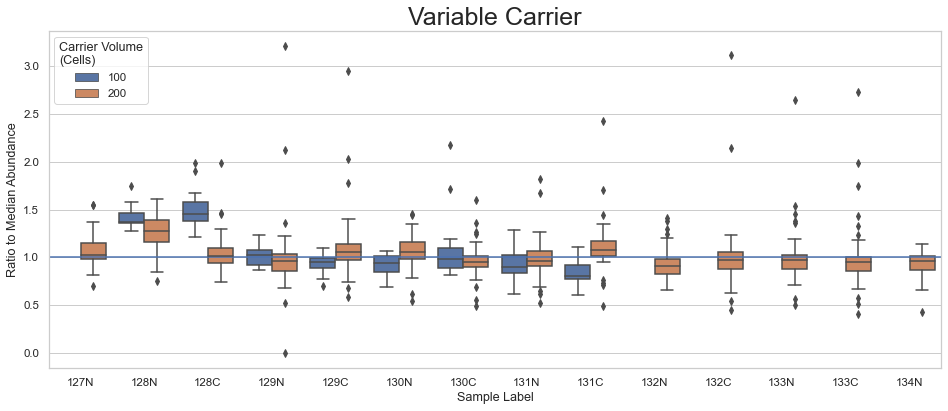

In [10]:
to_graph_df = pd.melt(variance_df, id_vars=["Boost"], value_vars=channels, ignore_index=False) # ,"131N","131C","132N","132C","133N","133C","134N"]
to_graph_df["Dataset"] = to_graph_df.index
to_graph_df

plt.figure(figsize=(16, 6.2025)) # Original: (16, 8.27)

sns.set(font_scale=1.05)
sns.set_style("whitegrid")

title = "Variable Carrier"

boxplot = sns.boxplot(data=to_graph_df, x="variable", y="value", hue="Boost", order=channels)
# boxplot = sns.stripplot(data=to_graph_df, x="variable", y="value", jitter=True, hue="Boost", order=channels)
    
plt.legend(title="Carrier Volume\n(Cells)") # , alignment="center") # Need to Update matplotlib


boxplot.set_title(title, fontsize=25)

plt.axhline(y=1)

boxplot.set(xlabel="Sample Label", ylabel="Ratio to Median Abundance") # Change y label

plt.savefig("overall_median_figure.png", dpi=400)
plt.show()

In [16]:
test_df = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
# reshape the d dataframe suitable for statsmodels package
test_df = test_df.rename(columns={"A": "126"})
test_df.at[3, "B"] = np.nan
df_melt = pd.melt(test_df.reset_index(), id_vars=['index'], value_vars=['126', 'B', 'C', 'D'])
# replace column names
df_melt.columns = ['index', 'treatments', 'value']

df_melt

# res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary

# To Do:
# -Get the ANOVA working


# -Use open dots for blank channels, filled for samples
# 

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,2939.355263,979.785088,19.167625,0.000022
Residual,15.0,766.750000,51.116667,NaN,NaN
